In [1]:
!nvidia-smi

Sat Nov 30 19:32:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              6W /   60W |       8MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torchinfo
import sys
import os
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

In [5]:
mnist_train = datasets.MNIST(
    root= "../data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root = "../data",
    train = False,
    download=True,
    transform=transforms.ToTensor()
)

In [6]:
class_names = mnist_train.classes

In [7]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [8]:
targets_series = pd.Series(mnist_train.targets.numpy())
targets_series.value_counts().sort_index()

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

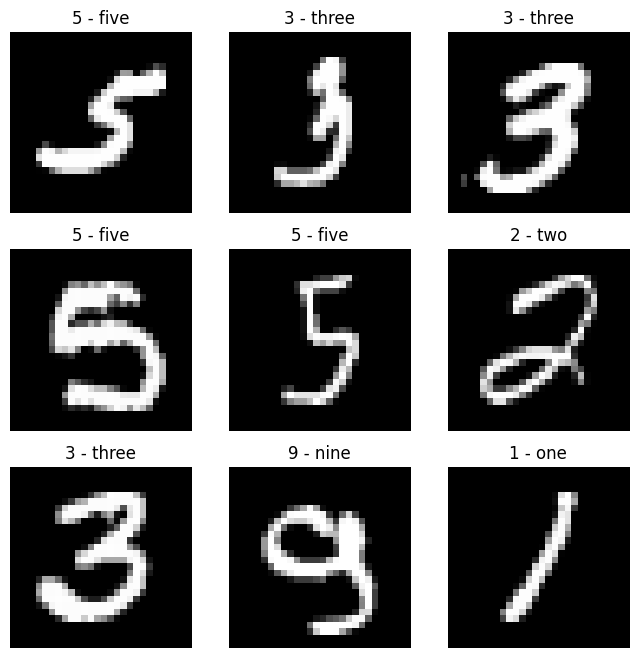

In [9]:
# Plot a random 9 train images in 3 * 3 grid
random_indices = torch.randint(0, len(mnist_train.data), (9,))
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(mnist_train.data[random_indices[i]], cmap='gray')
    plt.title(class_names[mnist_train.targets[random_indices[i]]])
    plt.axis(False)

In [10]:
BATCH_SIZE = 32
train_dataloader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class MNISTModelV0(nn.Module):
    def __init__(self, input_shape : int, output_shape : int, hidden_units : int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )
    def forward(self, x):
        return self.layer(x)

In [12]:
torch.manual_seed(42)
model = MNISTModelV0(28 * 28, len(class_names), 128)

In [13]:
model = model.cuda()

In [14]:
torchinfo.summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNISTModelV0                             [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 128]                 100,480
│    └─ReLU: 2-3                         [32, 128]                 --
│    └─Linear: 2-4                       [32, 128]                 16,512
│    └─ReLU: 2-5                         [32, 128]                 --
│    └─Linear: 2-6                       [32, 10]                  1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.79
Input size (MB): 0.10
Forward/backward pass size (MB): 0.07
Params size (MB): 0.47
Estimated Total Size (MB): 0.64

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
from tqdm.auto import tqdm
from pytorch_modules.utils import set_static_seed
set_static_seed()

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} of {EPOCHS}")
    for batch in tqdm(train_dataloader):
        images, labels = batch
        model.train()
        outputs = model(images.to(device))
        loss = loss_fn(outputs, labels.to(device))
        writer.add_scalar("Loss/train", loss, epoch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss: {loss.item()}")

/home/honey-trivedi/Coding/data-science/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1 of 10


100%|██████████| 1875/1875 [00:04<00:00, 386.57it/s]


Loss: 0.21845939755439758
Epoch 2 of 10


100%|██████████| 1875/1875 [00:04<00:00, 394.51it/s]


Loss: 0.03358371555805206
Epoch 3 of 10


100%|██████████| 1875/1875 [00:04<00:00, 401.13it/s]


Loss: 0.08521132171154022
Epoch 4 of 10


100%|██████████| 1875/1875 [00:04<00:00, 393.20it/s]


Loss: 0.01009353157132864
Epoch 5 of 10


100%|██████████| 1875/1875 [00:05<00:00, 366.25it/s]


Loss: 0.07456504553556442
Epoch 6 of 10


100%|██████████| 1875/1875 [00:04<00:00, 387.63it/s]


Loss: 0.004007365554571152
Epoch 7 of 10


100%|██████████| 1875/1875 [00:04<00:00, 383.94it/s]


Loss: 0.026350082829594612
Epoch 8 of 10


100%|██████████| 1875/1875 [00:04<00:00, 377.68it/s]


Loss: 0.0028315044473856688
Epoch 9 of 10


100%|██████████| 1875/1875 [00:04<00:00, 378.74it/s]


Loss: 0.00033729549613781273
Epoch 10 of 10


100%|██████████| 1875/1875 [00:05<00:00, 372.51it/s]

Loss: 0.01877053827047348


In [21]:
accuracy_metric = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

model.eval()
with torch.inference_mode():
    for batch in tqdm(test_dataloader):
        images : torch.Tensor
        labels : torch.Tensor
        images, labels = batch
        outputs = model(images.to(device))
        loss = loss_fn(outputs, labels.to(device))
        writer.add_scalar("Loss/test", loss, epoch)
        _, predicted = torch.max(outputs, dim=1)

        test_acc : torch.Tensor = accuracy_metric(predicted, labels.to(device))
        
print(f"Accuracy: {test_acc.item()}")

100%|██████████| 313/313 [00:00<00:00, 450.17it/s]

Accuracy: 1.0


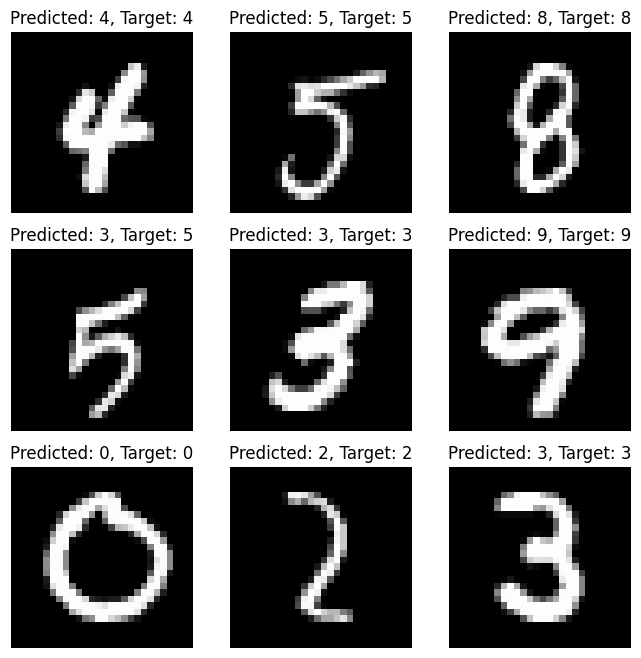

In [22]:
# Test the model on a random 9 test images
model.eval()
random_indices = torch.randint(0, len(mnist_test.data), (9,))
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(mnist_test.data[random_indices[i]], cmap='gray')
    image = mnist_test.data[random_indices[i]].unsqueeze(0).unsqueeze(0).float().to(device)
    _, predicted = torch.max(model(image), dim=1)
    plt.title(f"Predicted: {predicted.item()}, Target: {mnist_test.targets[random_indices[i]]}")
    plt.axis(False)

In [25]:
# Save the model
model_name = model.__class__.__name__.lower()
import datetime 
torch.save(model, f"../models/MNIST/{model_name}_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.pth")